In [ ]:
import json

data = json.load(
    open(
        "/Users/galyukshev/Desktop/NSS/smol-llm-research/gnn4taskplan_modeling/ultratool/tool_desc.json",
        "r",
    )
)
len(data)

1726

In [ ]:
from openai import OpenAI
import re

VSEGPT_KEY = "sk-or-vv-"


def call_vsegpt_model(model, prompt, **kwargs):
    try:
        client = OpenAI(
            api_key=VSEGPT_KEY,
            base_url="https://api.vsegpt.ru/v1",
        )
        messages = []
        messages.append({"role": "user", "content": prompt})
        response_big = client.chat.completions.create(
            model=model, messages=messages, **kwargs
        )

        response = response_big.choices[0].message.content
        print(response)
        response_data = re.sub(r"^```json\s*|```$", "", response.strip())
        response_data = re.sub(r"^```\s*|```$", "", response.strip())
        parsed_data = json.loads(response_data)
    except Exception as e:
        print(e)
        return []
    return parsed_data

In [ ]:
final_tools = []
model = "meta-llama/llama-3.3-70b-instruct"
cats = """
Finance  
Document  
Alarm  
Flight  
Train  
Repair  
Hotel  
Travel  
Meeting  
Agenda  
Cleaning  
Other  
Account  
Restaurant  
Weather  
Health  
Tracking  
Job  
News  
Rental  
Music  
Movie
"""
for i in range(0, len(data), 20):
    batch = data[i : i + 20]
    prompt = f"""Please assign a category to each of the following tools based on their functionality. 
    The available categories are: {cats}
    TOOLS_START {json.dumps(batch)} TOOLS_END 
    Return the tools with a new field 'category' added to each tool. 
    Without your comments. Only JSON. Without special characters. Return a list of dicts. And use only given categories!"""
    response = []
    while not response:
        response = call_vsegpt_model(model, prompt)
    print(response)
    final_tools.extend(response)
    with open(
        "/Users/galyukshev/Desktop/NSS/smol-llm-research/gnn4taskplan_modeling/ultratool/tool_desc_with_original_cats.json",
        "w",
    ) as f:
        json.dump(final_tools, f, ensure_ascii=False, indent=4)

[
    {"name": "file_character_count", "description": "Count the number of characters in a file and return", "category": "Document"},
    {"name": "file_rename", "description": "Used to change the name of a file.", "category": "Document"},
    {"name": "file_write", "description": "Used to write content to a specified file. If the file does not exist, a new file will be created.", "category": "Document"},
    {"name": "update_hyperlinks_text", "description": "Update all hyperlinks in the document that reference the specified text, updating their text to new text", "category": "Document"},
    {"name": "file_copy", "description": "Used for copying files to a specified path.", "category": "Document"},
    {"name": "set_file_readonly", "description": "Set file permission to read-only", "category": "Document"},
    {"name": "set_file_encoding", "description": "Set the encoding format of a specified file", "category": "Document"},
    {"name": "file_contains", "description": "Check if the f

Category Percentages:
Finance: 14.43%
Other: 13.67%
Document: 10.54%
Travel: 8.63%
Meeting: 7.71%
Flight: 6.03%
Hotel: 5.97%
Account: 5.68%
Repair: 4.87%
Alarm: 4.69%
Agenda: 3.36%
Train: 3.01%
Restaurant: 2.67%
Health: 2.38%
Rental: 1.27%
Tracking: 1.04%
News: 0.87%
Weather: 0.81%
Job: 0.75%
Music: 0.75%
Cleaning: 0.58%
Movie: 0.29%


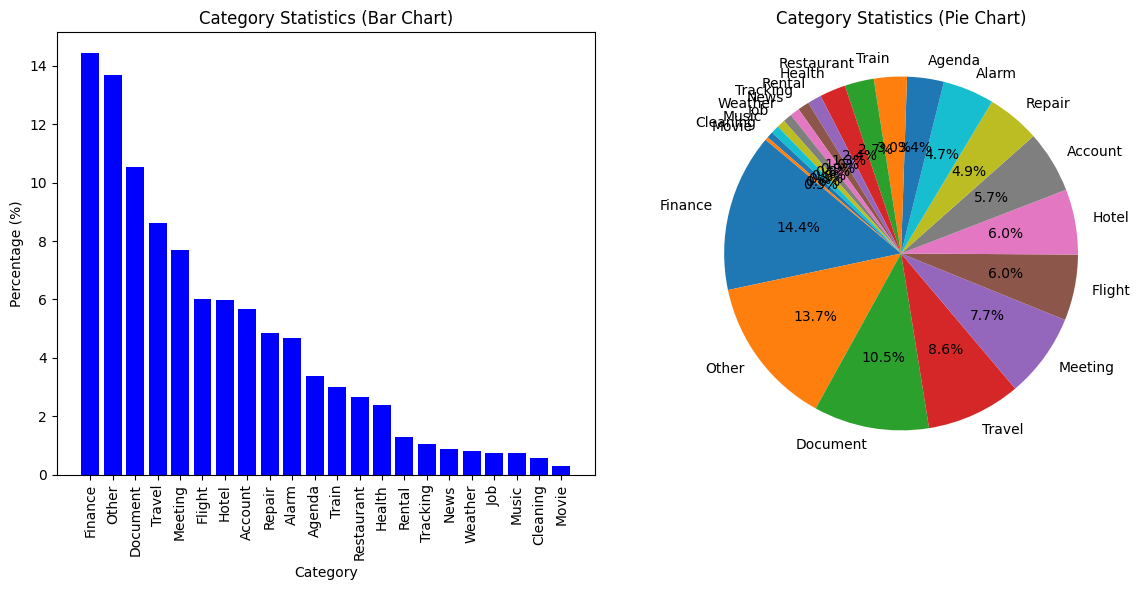

In [48]:
import json
from collections import Counter
import matplotlib.pyplot as plt

# Path to your JSON file
json_file_path = "/Users/galyukshev/Desktop/NSS/smol-llm-research/gnn4taskplan_modeling/ultratool/tool_desc_with_original_cats.json"

# Load JSON data from the file
with open(json_file_path, "r") as file:
    data = json.load(file)

# Extract the categories from each entry
categories = [entry["category"] for entry in data]

# Compute statistics: count the occurrences of each category
category_counts = Counter(categories)

# Calculate total number of entries (tools)
total_count = sum(category_counts.values())

# Create a dictionary with percentages for each category
category_percents = {
    cat: (count / total_count) * 100 for cat, count in category_counts.items()
}

# Sort the categories by percentage in descending order
sorted_categories = sorted(category_percents.items(), key=lambda x: x[1], reverse=True)
sorted_names, sorted_percents = zip(*sorted_categories)

# Print category percentages
print("Category Percentages:")
for category, percent in sorted_categories:
    print(f"{category}: {percent:.2f}%")

# Plotting the sorted category percentages as a bar chart
plt.figure(figsize=(12, 6))

# Bar Chart
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.bar(sorted_names, sorted_percents, color="blue")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.title("Category Statistics (Bar Chart)")
plt.xticks(rotation=90)

# Pie Chart
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.pie(sorted_percents, labels=sorted_names, autopct="%1.1f%%", startangle=140)
plt.title("Category Statistics (Pie Chart)")
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
from typing import TypedDict, Callable, Dict, Any, List, Optional
from langchain_openai import ChatOpenAI
import warnings

warnings.filterwarnings("ignore")

VSEGPT_KEY = "sk-or-vv-"

llm = ChatOpenAI(
    model_name="meta-llama/llama-3.3-70b-instruct",
    openai_api_key=VSEGPT_KEY,
    openai_api_base="https://api.vsegpt.ru/v1",
)


class InputState(TypedDict):
    user_input: str


class OutputState(TypedDict):
    graph_output: str


class OverallState(TypedDict):
    foo: str
    user_input: str
    graph_output: str


class PrivateState(TypedDict):
    bar: str


class ToolMetadata(TypedDict):
    id: str
    desc: str


def create_tool_node(metadata: ToolMetadata) -> Callable[[OverallState], OverallState]:
    def tool_node(state: OverallState) -> OverallState:
        chosen_tool = metadata["id"]
        print(
            f"[Tool Call] Current tool: '{chosen_tool}'. Description: {metadata['desc']}"
        )
        previous = state.get("graph_output", "")
        state["graph_output"] = (
            f"{previous}\nAgent selected: {chosen_tool} ({metadata['desc']})"
        )
        return state

    return tool_node


class StateGraph:
    def __init__(self, overall_state_type: Any, input: Any, output: Any):
        self.nodes: Dict[str, Callable[[OverallState], OverallState]] = {}
        self.edges: List[tuple] = []
        self.START = "START"
        self.END = "END"

    def add_node(self, name: str, func: Callable[[OverallState], OverallState]) -> None:
        self.nodes[name] = func

    def add_edge(self, from_node: str, to_node: str) -> None:
        self.edges.append((from_node, to_node))

    def get_next_node(self, current_node: str) -> Optional[str]:
        for source, target in self.edges:
            if source == current_node:
                return target
        return None

    def execute_graph(
        self, initial_state: OverallState, start_node: str, max_iterations: int = 20
    ) -> OverallState:
        state = initial_state.copy()
        current_node = start_node
        iteration = 0
        while (
            current_node is not None
            and current_node != self.END
            and iteration < max_iterations
        ):
            print(f"\n[Graph] Current node: {current_node}")
            if current_node in self.nodes:
                state = self.nodes[current_node](state)
            else:
                print(f"[Warning] Node {current_node} not in graph")
            approved = supervisor_decision_llm(state)
            if not approved:
                print(f"[Supervisor] Supervisor has stoped on {current_node}.")
                break
            current_node = self.get_next_node(current_node)
            iteration += 1
        if iteration >= max_iterations:
            print("[Graph] Limit reached")
        return state


tools_json = {
    "links": [
        {"source": "GetCollectionDetail", "target": "GetCollectionImage"},
        {"source": "GetCollectionImage", "target": "GetCompanyDetail"},
        {"source": "GetCompanyDetail", "target": "GetCollectionDetail"},
    ],
    "nodes": [
        {
            "desc": "[Collection Detail] Retrieve details for a collection based on its ID.",
            "id": "GetCollectionDetail",
        },
        {
            "desc": "[Collection Image] Retrieve a collection's images based on its ID.",
            "id": "GetCollectionImage",
        },
        {
            "desc": "[Company Detail] Retrieve details about a company based on its ID.",
            "id": "GetCompanyDetail",
        },
    ],
}

builder = StateGraph(OverallState, input=InputState, output=OutputState)
for tool in tools_json["nodes"]:
    node_func = create_tool_node(tool)
    builder.add_node(tool["id"], node_func)
for link in tools_json["links"]:
    builder.add_edge(link["source"], link["target"])
builder.add_edge(builder.START, "GetCollectionDetail")
builder.add_edge("GetCompanyDetail", builder.END)


def supervisor_decision_llm(state: OverallState) -> bool:
    prompt = (
        "You are a supervisor. You need to validate agent's answers\n"
        f"Current state:\n{state}\n"
        "Doest this state resolve request? Say only 'yes' or 'no'"
    )
    response = llm(prompt).content.lower()
    print(f"[LLM Supervisor] Request: {prompt}\Response: {response}")
    if "yes" in response:
        return False
    else:
        return True


def executor_agent(initial_state: OverallState, starting_tool: str) -> OverallState:
    final_state = builder.execute_graph(initial_state, starting_tool)
    return final_state


initial_state: OverallState = {
    "user_input": "User's request: I need to get collection's images based on its ID",
    "graph_output": "",
}

final_state = executor_agent(initial_state, starting_tool="GetCollectionDetail")
print("\nStates:", final_state["graph_output"])


[Graph] Current node: GetCollectionDetail
[Tool Call] Current tool: 'GetCollectionDetail'. Description: [Collection Detail] Retrieve details for a collection based on its ID.
[LLM Supervisor] Request: You are a supervisor. You need to validate agent's answersCurrent state:
{'user_input': "User's request: I need to get collection's images based on its ID", 'graph_output': '\nAgent selected: GetCollectionDetail ([Collection Detail] Retrieve details for a collection based on its ID.)'}
Doest this state resolve request? Say only 'yes' or 'no'\Response: no

[Graph] Current node: GetCollectionImage
[Tool Call] Current tool: 'GetCollectionImage'. Description: [Collection Image] Retrieve a collection's images based on its ID.
[LLM Supervisor] Request: You are a supervisor. You need to validate agent's answersCurrent state:
{'user_input': "User's request: I need to get collection's images based on its ID", 'graph_output': "\nAgent selected: GetCollectionDetail ([Collection Detail] Retrieve det